2024-07-11 01:50:13,416 - INFO - Starting MOT loading and compression with 10000 atoms at 293150000.00 μK
2024-07-11 01:50:13,424 - INFO - Time: 0.0 ms, Atoms: 10000, Temperature: 293895360.44 μK


Running initial simulation...


2024-07-11 01:50:18,126 - INFO - Time: 10.0 ms, Atoms: 9994, Temperature: 293954668.12 μK
2024-07-11 01:50:22,285 - INFO - Time: 20.0 ms, Atoms: 9982, Temperature: 294046253.77 μK
2024-07-11 01:50:26,578 - INFO - Time: 30.0 ms, Atoms: 9976, Temperature: 294317114.68 μK
2024-07-11 01:50:30,843 - INFO - Time: 40.0 ms, Atoms: 9966, Temperature: 294684772.46 μK
2024-07-11 01:50:35,806 - INFO - Time: 50.0 ms, Atoms: 9956, Temperature: 295468970.68 μK
2024-07-11 01:50:40,256 - INFO - Time: 59.9 ms, Atoms: 9945, Temperature: 296575436.24 μK
2024-07-11 01:50:44,564 - INFO - Time: 69.9 ms, Atoms: 9938, Temperature: 298468931.01 μK
2024-07-11 01:50:49,345 - INFO - Time: 79.9 ms, Atoms: 9927, Temperature: 301309572.83 μK
2024-07-11 01:50:53,872 - INFO - Time: 89.9 ms, Atoms: 9919, Temperature: 305544418.17 μK
2024-07-11 01:50:57,833 - INFO - Time: 99.9 ms, Atoms: 9906, Temperature: 321330707.52 μK
2024-07-11 01:50:57,849 - INFO - MOT and gray molasses complete. Final atoms: 9906, Final temperatur

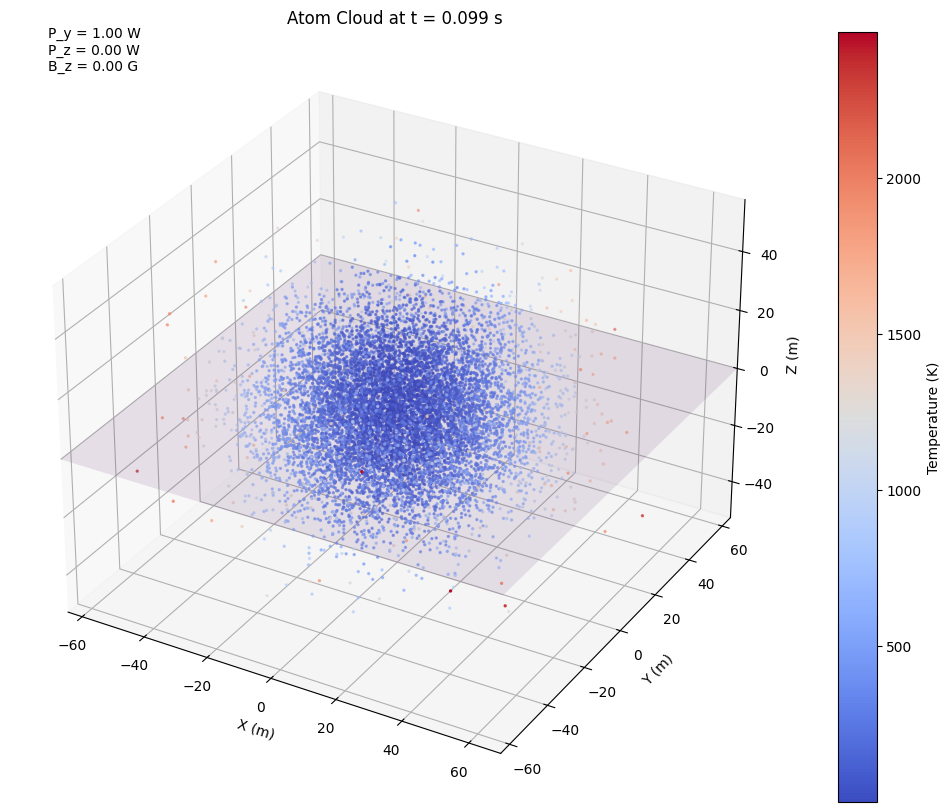

/var/folders/bz/9tqsqmh90592y3_wn1lrvm040000gn/T/ipykernel_70548/2577086164.py:1630: RankWarning: Polyfit may be poorly conditioned
  plot_psd_vs_n(results)


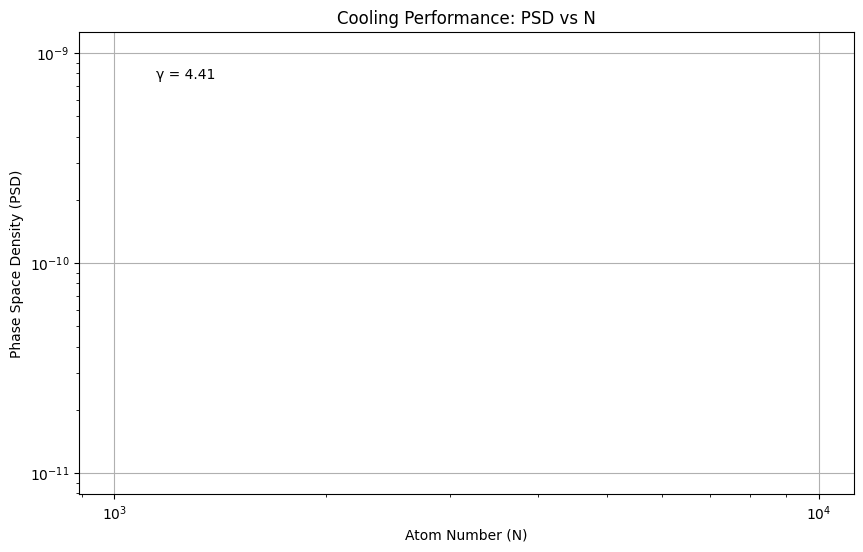

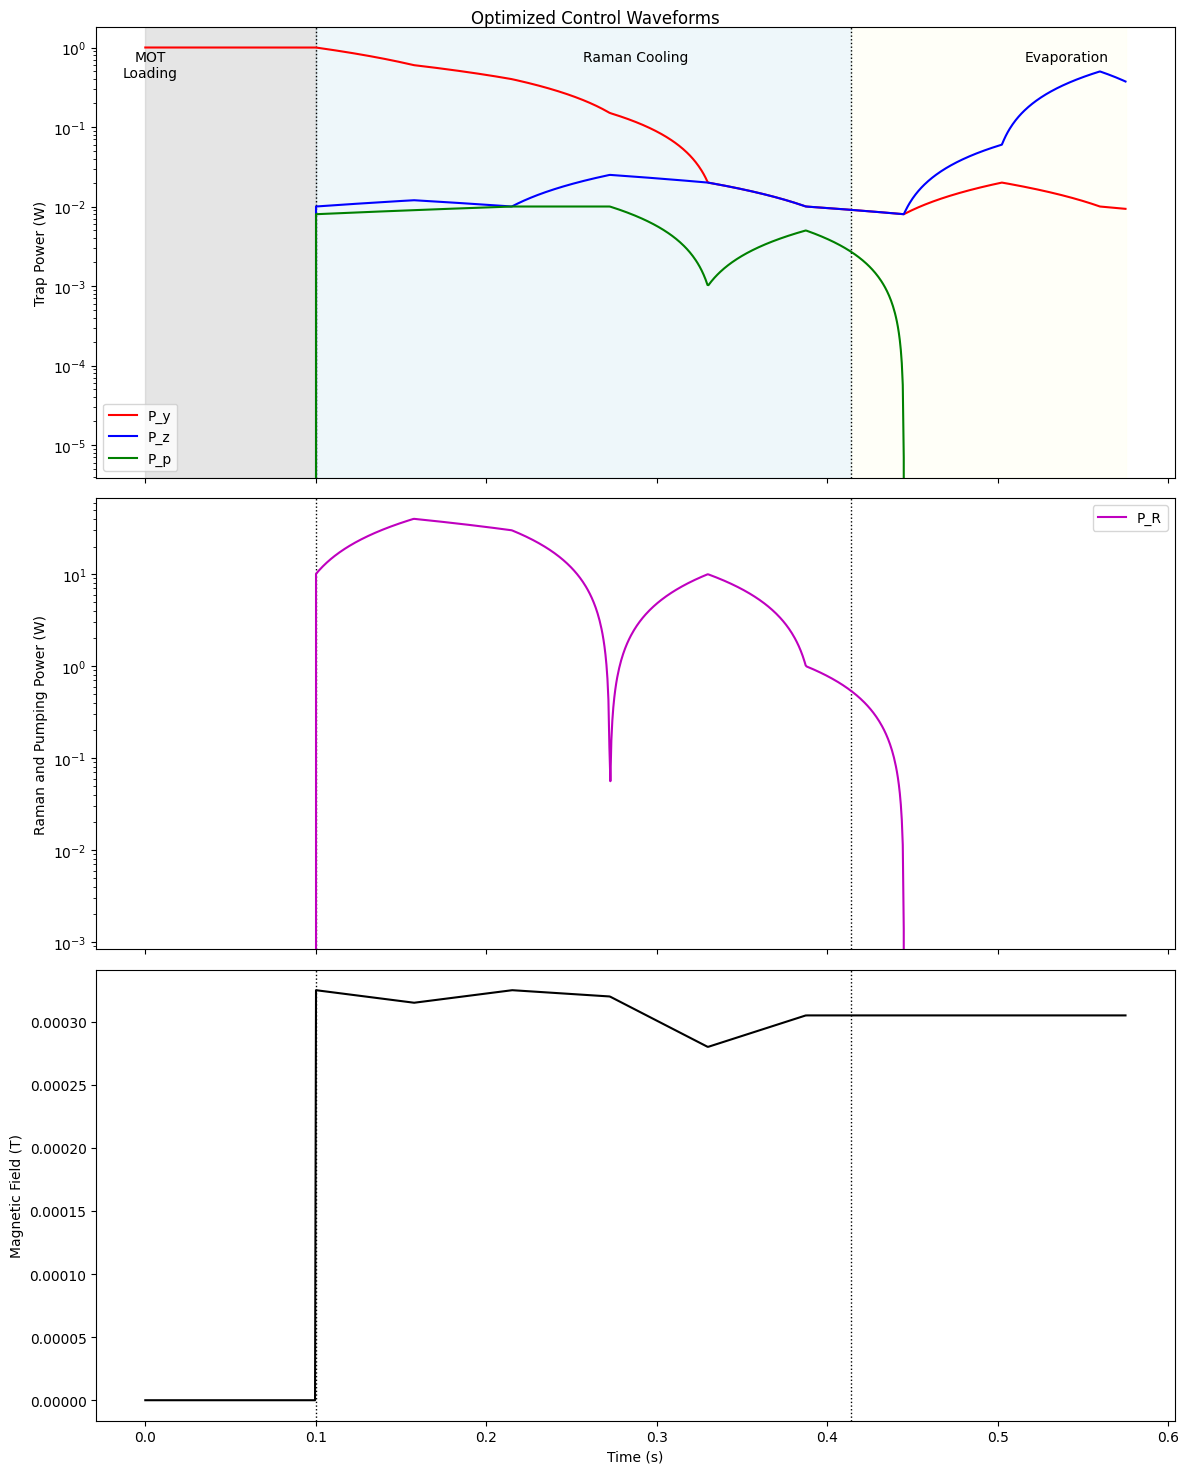

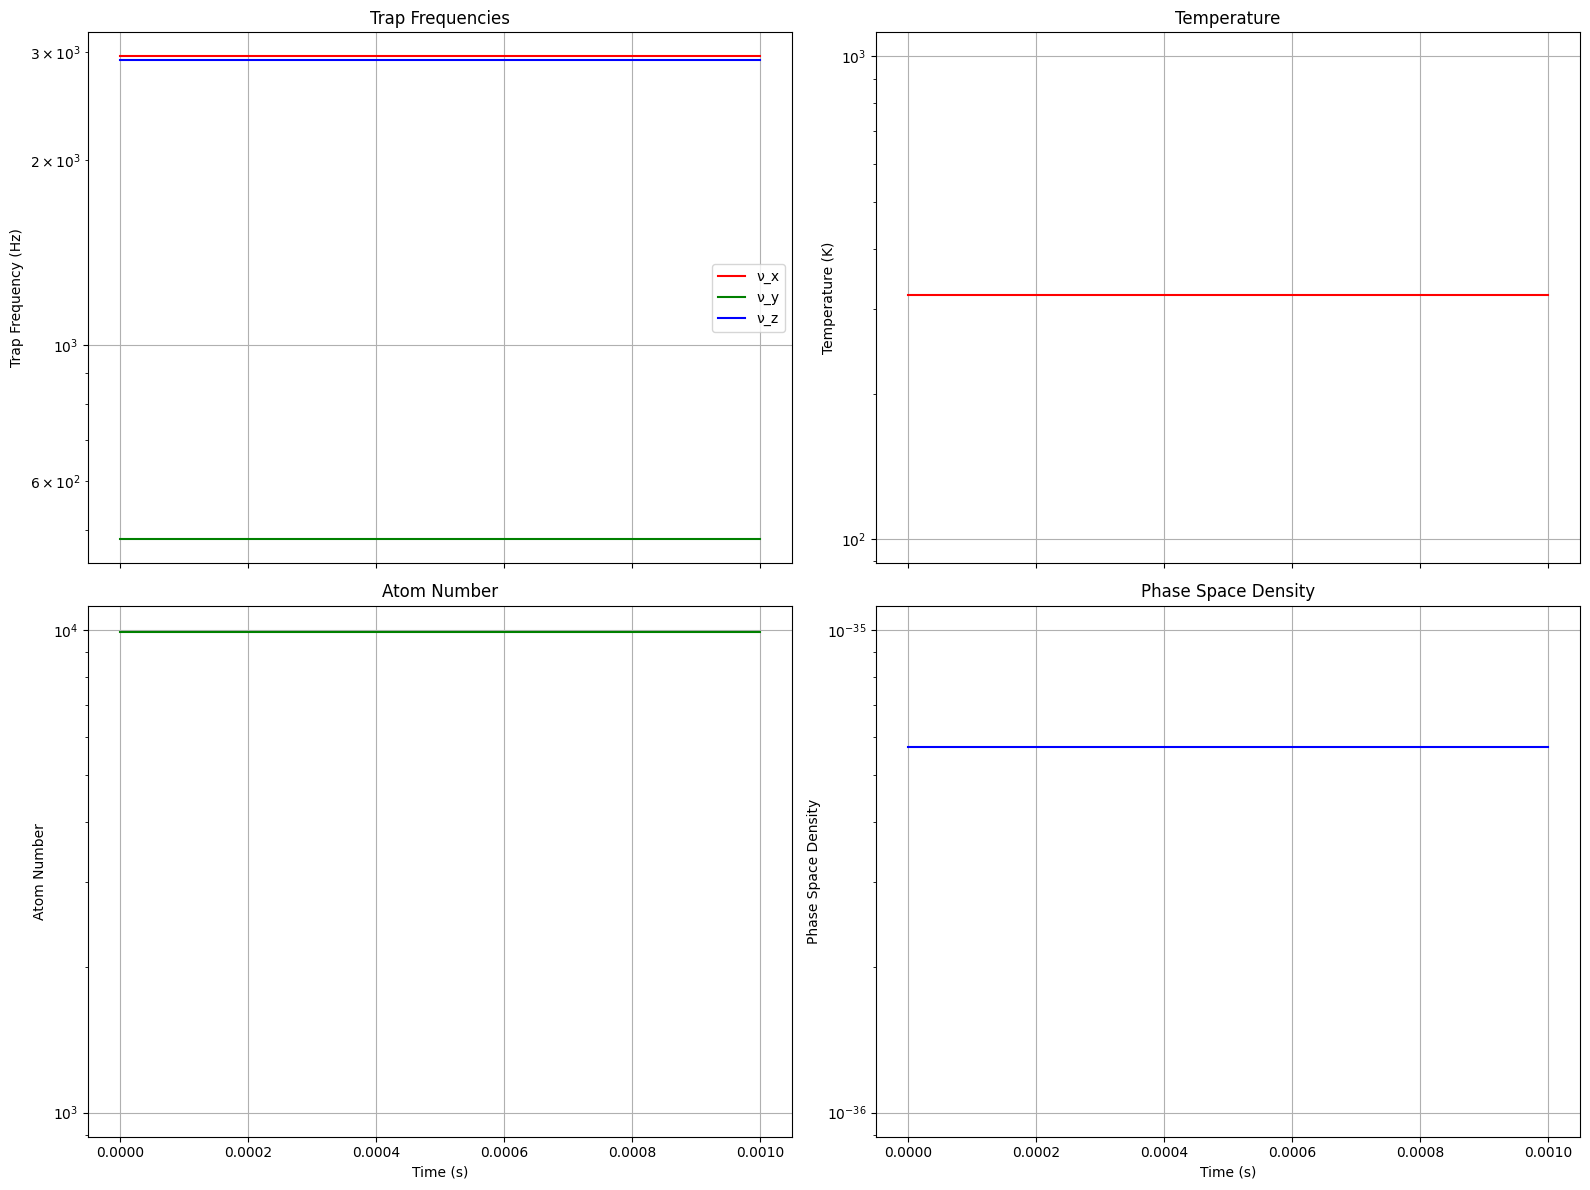

2024-07-11 01:51:38,530 - ERROR - Error in validate_simulation: object of type 'NoneType' has no len()
Traceback (most recent call last):
  File "/var/folders/bz/9tqsqmh90592y3_wn1lrvm040000gn/T/ipykernel_70548/2577086164.py", line 1714, in initial_simulation_run
    validate_simulation(results, trap_frequencies, params_init, trap, cooling_efficiencies, condensate_fractions)
  File "/var/folders/bz/9tqsqmh90592y3_wn1lrvm040000gn/T/ipykernel_70548/2577086164.py", line 1636, in validate_simulation
    plot_results(results, cooling_efficiencies, condensate_fractions)
  File "/var/folders/bz/9tqsqmh90592y3_wn1lrvm040000gn/T/ipykernel_70548/2577086164.py", line 1515, in plot_results
    axs[1, 1].plot(range(len(condensate_fractions)), condensate_fractions, 'm-')
TypeError: object of type 'NoneType' has no len()
2024-07-11 01:51:38,538 - INFO - Starting MOT loading and compression with 10000 atoms at 293150000.00 μK
2024-07-11 01:51:38,545 - INFO - Time: 0.0 ms, Atoms: 10000, Temperature: 29

Starting optimization process...


2024-07-11 01:51:43,158 - INFO - Time: 10.0 ms, Atoms: 9984, Temperature: 296156034.04 μK


KeyboardInterrupt: 

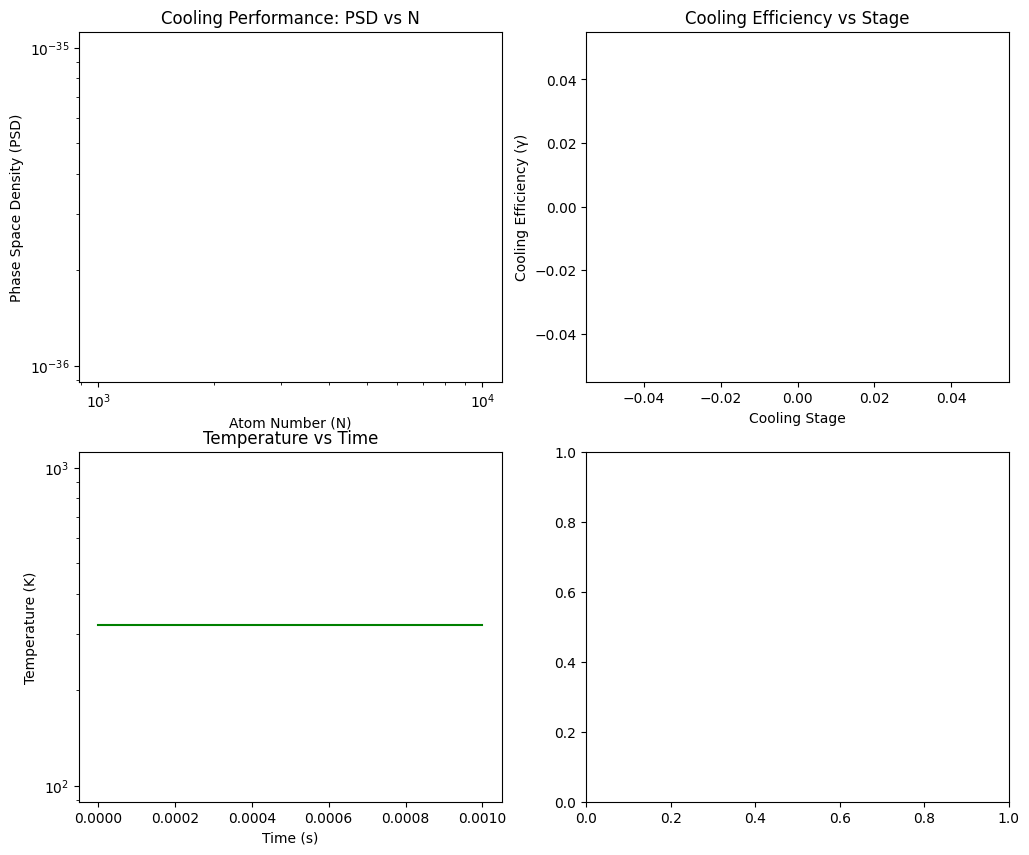

In [15]:
import numpy as np
from scipy.constants import h, hbar, k, atomic_mass, mu_0, g, c, epsilon_0
from scipy.stats import maxwell
from scipy.optimize import minimize
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from scipy.optimize import curve_fit, minimize_scalar
from scipy.interpolate import interp1d
from scipy.spatial import ConvexHull
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation, writers
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Rubidium-87 properties
class Rb87:
    mass = 86.909180527 * atomic_mass
    wavelength_D1 = 794.979e-9  # meters
    wavelength_D2 = 780.241e-9  # meters
    gamma_D1 = 2 * np.pi * 5.746e6  # rad/s
    gamma_D2 = 2 * np.pi * 6.065e6  # rad/s
    a_s = 98 * 5.29e-11  # s-wave scattering length in meters
    g_F = 1/2  # Landé g-factor for F=2 state
    mu_B = 9.274e-24  # Bohr magneton in J/T
    ground_state_F2 = 2
    ground_state_F1 = 1
    m_F_dark = -2
    hyperfine_splitting = 6.834682610904e9  # Hyperfine splitting frequency in Hz
    

    
    # Calculate recoil energy for D1 transition
    Er_D1 = (h / wavelength_D1)**2 / (2 * mass)  # Joules
    
    # Calculate recoil velocity for D1 transition
    vr_D1 = h / (mass * wavelength_D1)  # m/s

    # Saturation intensity for Rb87 D1 line
    I_sat_D1 = 1.49  # mW/cm^2
    
    # Saturation intensity for Rb87 D2 line
    I_sat_D2 = 1.67  # mW/cm^2

    @classmethod
    def calculate_trap_frequency(cls, P, w0, wavelength):
        # Calculate trap frequency for a given beam power, waist, and wavelength
        U0 = 2 * cls.calculate_polarizability(wavelength) * P / (np.pi * c * epsilon_0 * w0**2)
        return np.sqrt(4 * U0 / (cls.mass * w0**2))

    @classmethod
    def calculate_polarizability(cls, wavelength):
        # This is a simplified calculation and might need to be adjusted for accuracy
        return 5.3e-39  # m^3, approximate value for 1064 nm
    
    @classmethod
    def calculate_K3(cls, T):
        K3_0 = 4.3e-29  # cm^6/s for Rb-87 in |2, -2⟩ state
        T_scale = 100e-6  # 100 μK
        return K3_0 * (1 + (T / T_scale)**2) * 1e-12  # Convert to m^6/s

class BeamParameters:
    odt_horizontal_waist = 18e-6  # 18 μm
    odt_vertical_waist = 14e-6    # 14 μm
    raman_waist = 500e-6          # 500 μm
    op_waist_x = 30e-6            # 30 μm
    op_waist_y = 1e-3             # 1 mm
    
# Simulation parameters
N_atoms_initial = int(1e4)
T_initial = 300e-6
dt = 1e-5

class LaserBeam:
    def __init__(self, power, w_x, w_y, wavelength, direction=[0, 0, 1]):
        self.power = power
        self.w_x = w_x
        self.w_y = w_y
        self.wavelength = wavelength
        self.k = 2 * np.pi / wavelength * np.array(direction) / np.linalg.norm(direction)

    def intensity(self, positions):
        x, y, _ = positions.T
        return 2 * self.power / (np.pi * self.w_x * self.w_y) * np.exp(-2 * (x**2 / self.w_x**2 + y**2 / self.w_y**2))
    

class AtomCloud:
    def __init__(self, N, T, trap):
        self.N = int(max(round(N), 1))
        self.trap = trap
        self.T = np.full(self.N, max(T, 1e-9))  # Initialize temperature array
        self.positions = self.initialize_positions()
        self.velocities = self.initialize_velocities()
        self.light_shift = np.zeros(self.N)
        self.F = np.full(self.N, Rb87.ground_state_F2)  # Initialize all atoms in F=2 state
        self.m_F = np.full(self.N, Rb87.m_F_dark)  # Initialize all atoms in m_F=-2 state
        self.max_atom_change_ratio = 0.1  # Maximum allowed fractional change in atom number per time step
        self.check_consistency()

    def get_atom_data(self):
        return self.positions, self.T



    def initialize_positions(self):
        epsilon = 1e-10
        
        sigma_x = np.sqrt(k * np.mean(self.T) / (Rb87.mass * (self.trap.omega_x**2 + epsilon)))
        sigma_y = np.sqrt(k * np.mean(self.T) / (Rb87.mass * (self.trap.omega_y**2 + epsilon)))
        sigma_z = np.sqrt(k * np.mean(self.T) / (Rb87.mass * (self.trap.omega_z**2 + epsilon)))
        
        x = np.random.normal(0, sigma_x, self.N)
        y = np.random.normal(0, sigma_y, self.N)
        z = np.random.normal(0, sigma_z, self.N)
        
        return np.column_stack((x, y, z))
        

    def initialize_velocities(self):
        sigma_v = np.sqrt(k * self.T[:, np.newaxis] / Rb87.mass)
        return np.random.normal(0, sigma_v, (self.N, 3))
    
    def add_atoms(self, new_atoms, new_positions, new_velocities, new_temperature):
        if new_atoms <= 0:
            return

        old_N = self.N
        self.N += new_atoms

        # Extend arrays
        self.positions = np.vstack((self.positions, new_positions))
        self.velocities = np.vstack((self.velocities, new_velocities))
        self.T = np.concatenate((self.T, np.full(new_atoms, new_temperature)))
        self.light_shift = np.concatenate((self.light_shift, np.zeros(new_atoms)))
        self.F = np.concatenate((self.F, np.full(new_atoms, Rb87.ground_state_F2)))
        self.m_F = np.concatenate((self.m_F, np.full(new_atoms, Rb87.m_F_dark)))

        self.check_consistency()
    
    def force_sync(self):
        try:
            min_length = min(len(self.positions), len(self.velocities), len(self.T), len(self.light_shift))
            self.positions = self.positions[:min_length]
            self.velocities = self.velocities[:min_length]
            self.T = self.T[:min_length]
            self.light_shift = self.light_shift[:min_length]
            self.N = min_length
            self.check_consistency()
            logging.debug(f"After force_sync: N = {self.N}, "
                          f"positions shape = {self.positions.shape}, "
                          f"velocities shape = {self.velocities.shape}, "
                          f"T shape = {self.T.shape}, "
                          f"light_shift shape = {self.light_shift.shape}")
        except Exception as e:
            logging.error(f"Error in force_sync: {e}")
            raise

    def update(self, dt):
        if self.positions is None or self.velocities is None:
            logging.error("Positions or velocities are None in update method")
            raise ValueError("Invalid atom cloud state")
        self.positions += self.velocities * dt
        self.update_temperature()
        self.check_consistency()

    def update_temperature(self):
        if self.velocities is None:
            logging.error("Velocities are None in update_temperature method")
            raise ValueError("Invalid atom cloud state")
        if self.N > 0:
            kinetic_energy = 0.5 * Rb87.mass * np.sum(self.velocities**2, axis=1)
            self.T = 2 * kinetic_energy / (3 * k)
        else:
            self.T = np.array([1e-9])  # Set to 1 nK if no atoms left


    """
    def update_positions_velocities(self, dt):
        # Update positions and velocities using the Verlet algorithm
        acceleration = -self.trap.calculate_force(self.positions) / Rb87.mass
        self.positions += self.velocities * dt + 0.5 * acceleration * dt**2
        new_acceleration = -self.trap.calculate_force(self.positions) / Rb87.mass
        self.velocities += 0.5 * (acceleration + new_acceleration) * dt
    """
    def update_velocities(self):
        # Add a small epsilon to prevent division by zero
        epsilon = 1e-10
        sigma_v = np.sqrt(k * self.T / Rb87.mass)
        sigma_x = np.sqrt(k * np.mean(self.T) / (Rb87.mass * (self.trap.omega_x**2 + epsilon)))
        sigma_y = np.sqrt(k * np.mean(self.T) / (Rb87.mass * (self.trap.omega_y**2 + epsilon)))
        sigma_z = np.sqrt(k * np.mean(self.T) / (Rb87.mass * (self.trap.omega_z**2 + epsilon)))
        
        self.velocities = np.random.normal(0, sigma_v[:, np.newaxis], (self.N, 3))
        self.positions = np.column_stack((
            np.random.normal(0, sigma_x, self.N),
            np.random.normal(0, sigma_y, self.N),
            np.random.normal(0, sigma_z, self.N)
        ))

    def apply_light_shift(self, P_p, delta, sigma_minus_beam):
        I = sigma_minus_beam.intensity(self.positions)
        I_sat = 1.67
        self.light_shift = hbar * Rb87.gamma_D1**2 * I / (8 * delta * I_sat)

    def apply_losses(self, loss_rates, dt):
        # Apply atom losses
        total_loss_rate = sum(loss_rates.values())
        survival_prob = np.exp(-total_loss_rate * dt)
        mask = np.random.random(self.N) < survival_prob
        
        self.positions = self.positions[mask]
        self.velocities = self.velocities[mask]
        self.T = self.T[mask]
        self.light_shift = self.light_shift[mask]
        self.F = self.F[mask]
        self.m_F = self.m_F[mask]
        
        self.N = len(self.positions)
        self.check_consistency()


    def apply_gray_molasses(self, duration):
        cooling_rate = 1e-1
        self.T *= np.exp(-cooling_rate * duration)

    def apply_light_assisted_collisions(self, P_p, delta):
        n = self.calculate_density()
        n = min(n, 1e19)  # Cap density at a realistic maximum value
        
        # Adjust intensity calculation
        beam_area = np.pi * self.trap.w_y * self.trap.w_z
        intensity = min(P_p / beam_area, 1e3)  # Cap intensity at 1000 W/m^2
        intensity_mW_cm2 = intensity * 1e-1  # Convert to mW/cm^2
    
        K_2 = photoassociation_loss_rate(delta, intensity_mW_cm2)
        
        loss_rate = K_2 * n * dt
        survival_prob = np.exp(-loss_rate)
        new_N = int(self.N * survival_prob)
        self.N = max(new_N, 1)  # Ensure at least 1 atom remains

        # Only update positions and velocities if atoms are actually lost
        if new_N < self.N:
            if len(self.positions) > new_N:
                indices = np.random.choice(len(self.positions), new_N, replace=False)
                self.positions = self.positions[indices]
                self.velocities = self.velocities[indices]

    def apply_odt_transition_monte_carlo(self, old_trap, new_trap, transition_progress):
        # Calculate potential energy in old and new traps
        old_potential = old_trap.calculate_potential(self.positions)
        new_potential = new_trap.calculate_potential(self.positions)
        
        # Calculate kinetic energy
        kinetic_energy = 0.5 * Rb87.mass * np.sum(self.velocities**2, axis=1)
        
        # Total energy in old trap
        total_energy_old = old_potential + kinetic_energy
        
        # Calculate the maximum allowed energy in the new trap
        max_allowed_energy = new_trap.calculate_trap_depth()
        
        # Calculate loss probability for each atom
        loss_probability = np.clip((total_energy_old - max_allowed_energy) / max_allowed_energy, 0, 1)
        
        # Monte Carlo decision for each atom
        random_numbers = np.random.random(self.N)
        retained_mask = random_numbers > loss_probability
        
        # Update atom number
        self.N = np.sum(retained_mask)
        
        if self.N > 0:
            # Update positions and velocities for retained atoms
            self.positions = self.positions[retained_mask]
            self.velocities = self.velocities[retained_mask]
            self.T = self.T[retained_mask]
            
            # Redistribute excess energy between potential and kinetic
            excess_energy = np.maximum(total_energy_old[retained_mask] - new_potential[retained_mask], 0)
            new_kinetic_energy = kinetic_energy[retained_mask] + 0.5 * excess_energy
            
            # Update velocities based on new kinetic energy
            velocity_scaling = np.sqrt(new_kinetic_energy / kinetic_energy[retained_mask])
            self.velocities *= velocity_scaling[:, np.newaxis]
            
            # Update temperature
            self.T *= np.mean(velocity_scaling**2)
        
        else:
            # If all atoms are lost, reinitialize with a small number of atoms
            self.N = 1
            self.T = np.array([1e-6])  # 1 µK
            self.positions = new_trap.get_trap_center().reshape(1, 3)
            self.velocities = np.zeros((1, 3))
        
        # Update light shift
        self.light_shift = self.light_shift[retained_mask] if self.N > 1 else np.zeros(1)


    def apply_subrecoil_cooling(self, v_eff_recoil):
        """Apply subrecoil cooling to atoms below the effective recoil limit."""
        v_magnitude = np.linalg.norm(self.velocities, axis=1)
        subrecoil_mask = v_magnitude < v_eff_recoil
        cooling_strength = np.exp(-(v_magnitude[subrecoil_mask] / v_eff_recoil)**2)
        self.velocities[subrecoil_mask] *= np.maximum(0, 1 - cooling_strength[:, np.newaxis])

    def apply_three_body_recombination(self):
        n = self.calculate_density()
        K_3 = Rb87.calculate_K3(np.mean(self.T))
        loss_rate = K_3 * n**2 * dt
        survival_prob = np.exp(-loss_rate)
        initial_N = self.N
        new_N = int(self.N * survival_prob)
        atoms_lost = initial_N - new_N
        
        if new_N < self.N:
            indices = np.random.choice(self.N, new_N, replace=False)
            self.positions = self.positions[indices]
            self.velocities = self.velocities[indices]
            self.T = self.T[indices]
            self.N = new_N

        heating_rate = K_3 * n**2 * (Rb87.a_s * hbar)**2 / (2 * Rb87.mass) * 1e3
        self.T += heating_rate * dt

        # Add small probability of hot atoms remaining trapped
        hot_atom_prob = 0.01
        hot_atom_heating = atoms_lost * hot_atom_prob * 10 * k * np.mean(self.T) / (self.N * 3 * k)
        self.T += hot_atom_heating

        self.update_temperature()


    def apply_evaporative_cooling(self, trap_depth):
        # Simple evaporative cooling model
        eta = 10  # truncation parameter
        evap_prob = np.exp(-eta * np.mean(self.T) / trap_depth)
        atoms_to_remove = int(self.N * evap_prob)
        new_N = self.N - atoms_to_remove
        
        if new_N < self.N:
            indices = np.random.choice(self.N, new_N, replace=False)
            self.positions = self.positions[indices]
            self.velocities = self.velocities[indices]
            self.T = self.T[indices]
            self.N = new_N
        
        self.T *= 1 - evap_prob / 3  # Cooling effect
            

    def apply_photon_reabsorption_heating(self, P_p, delta):
        n = self.calculate_density()
        reabsorption_prob = n * 3 * Rb87.wavelength_D1**2 / (2 * np.pi)
        scattering_rate = P_p / (1 + 4 * delta**2 / Rb87.gamma_D1**2)
        heating_rate = reabsorption_prob * scattering_rate * 2 * Rb87.Er_D1 / (3 * k)
        self.T += heating_rate * dt

    def apply_magnetic_field(self, B_z):
        # Calculate the Zeeman shift
        zeeman_shift = Rb87.mu_B * Rb87.g_F * B_z
        
        # Apply the shift to the atoms' energies
        # This is a simplified approach; you may need to adjust it based on your specific requirements
        self.light_shift += zeeman_shift

    def check_consistency(self):
        attributes = [self.positions, self.velocities, self.T, self.light_shift, self.F, self.m_F]
        if any(attr is None for attr in attributes):
            logging.error("One or more attributes are None in check_consistency")
            raise ValueError("Invalid atom cloud state")
        if not all(len(attr) == self.N for attr in attributes):
            logging.error(f"Inconsistent lengths in AtomCloud attributes: N={self.N}, "
                          f"positions={len(self.positions)}, velocities={len(self.velocities)}, "
                          f"T={len(self.T)}, light_shift={len(self.light_shift)}, "
                          f"F={len(self.F)}, m_F={len(self.m_F)}")
            raise ValueError("Inconsistent AtomCloud state")


        
    # In the AtomCloud class, modify the calculate_density method:
    def calculate_density(self):
        if self.N < 2:
            return 0
        
        # Calculate the volume of the cloud using convex hull
        volume = np.prod(np.max(self.positions, axis=0) - np.min(self.positions, axis=0))
        return self.N / volume
    
    def calculate_temperature(self):
        """Calculate the temperature of each atom in the cloud."""
        if self.N == 0:
            logging.warning("Attempting to calculate temperature with zero atoms.")
            return 0.0
        
        velocities_squared = np.sum(self.velocities**2, axis=1)
        T = (Rb87.mass * velocities_squared) / (3 * k)
        
        if np.any(T < 0):
            logging.error(f"Calculated negative temperature: {T}")
            T = np.maximum(T, 1e-9)  # Set a minimum temperature of 1 nK
        
        return np.mean(T)


    def update_atom_number(self, new_N):
        try:
            old_N = self.N
            new_N = int(max(round(new_N), 1))  # Round and ensure at least one atom
            
            if self.N < old_N:
                # Remove excess atoms
                self.positions = self.positions[:self.N]
                self.velocities = self.velocities[:self.N]
                self.T = self.T[:self.N]
                self.light_shift = self.light_shift[:self.N]
            elif self.N > old_N:
                # Add new atoms
                additional_count = self.N - old_N
                new_positions = self.initialize_positions()[:additional_count]
                new_velocities = self.initialize_velocities()[:additional_count]
                self.positions = np.vstack((self.positions, new_positions))
                self.velocities = np.vstack((self.velocities, new_velocities))
                self.T = np.concatenate((self.T, np.full(additional_count, np.mean(self.T))))
                self.light_shift = np.concatenate((self.light_shift, np.zeros(additional_count)))
            
            self.check_consistency()
                
            #if new_N != old_N:
            #    logging.info(f"Atom number updated: {old_N} -> {new_N}")
        except Exception as e:
            logging.error(f"Error in update_atom_number: {e}")
            self.log_state()
            raise


    def log_state(self):
        logging.info(f"AtomCloud state: N = {self.N}, "
                     f"Mean T = {np.mean(self.T)*1e6:.2f} μK, "
                     f"Min T = {np.min(self.T)*1e6:.2f} μK, "
                     f"Max T = {np.max(self.T)*1e6:.2f} μK, "
                     f"positions shape = {self.positions.shape}, "
                     f"velocities shape = {self.velocities.shape}, "
                     f"Max velocity = {np.max(np.linalg.norm(self.velocities, axis=1)):.2f} m/s, "
                     f"Mean velocity = {np.mean(np.linalg.norm(self.velocities, axis=1)):.2f} m/s")


        

class TiltedDipleTrap:
    def __init__(self, P_y, P_z, w_y, w_z, wavelength, tilt_angle):
        self.P_y = P_y
        self.P_z = P_z
        self.w_y = w_y
        self.w_z = w_z
        self.wavelength = wavelength
        self.tilt_angle = tilt_angle
        self.k = 2 * np.pi / wavelength
        self.alpha = Rb87.calculate_polarizability(wavelength)
        self.z_R_y = np.pi * w_y**2 / wavelength
        self.z_R_z = np.pi * w_z**2 / wavelength
        self.update_trap_frequencies()

    def update_trap_frequencies(self):
        U0_y = self.P_y * 2 * self.alpha / (np.pi * c * epsilon_0 * self.w_y**2)
        U0_z = self.P_z * 2 * self.alpha / (np.pi * c * epsilon_0 * self.w_z**2)
        
        omega_x_squared = max(0, 4 * U0_y / (Rb87.mass * self.w_y**2) + 4 * U0_z / (Rb87.mass * self.w_z**2))
        self.omega_x = np.sqrt(omega_x_squared)
        
        omega_y_squared = max(0, 4 * U0_z / (Rb87.mass * self.w_z**2))
        self.omega_y = np.sqrt(omega_y_squared)
        
        omega_z_squared = 4 * U0_y / (Rb87.mass * self.w_y**2) - 2 * g * np.cos(self.tilt_angle) / self.w_y
        self.omega_z = np.sqrt(max(0, omega_z_squared))

    def update_powers(self, P_y, P_z):
        if P_y < 0 or P_z < 0:
            raise ValueError("Power values must be non-negative")
        self.P_y = P_y
        self.P_z = P_z
        self.update_trap_frequencies()

    def update_waists(self, w_y, w_z):
        if w_y <= 0 or w_z <= 0:
            raise ValueError("Waist values must be positive")
        self.w_y = w_y
        self.w_z = w_z
        self.update_trap_frequencies()

    
    def ramp_powers(self, t, ramp_duration, P_y_target, P_z_target):
        # Linearly ramp powers from current values to target values
        self.P_y = self.P_y + (P_y_target - self.P_y) * min(t / ramp_duration, 1)
        self.P_z = self.P_z + (P_z_target - self.P_z) * min(t / ramp_duration, 1)
        self.update_trap_frequencies()

    def update_tilt(self, tilt_angle):
        self.tilt_angle = tilt_angle
        self.update_trap_frequencies()

    def beam_potential(self, r, U0, w0, z_R):
        x, y, z = r
        w = w0 * np.sqrt(1 + (z/z_R)**2)
        return -U0 * (w0/w)**2 * np.exp(-2*(x**2 + y**2)/w**2)
    
    def calculate_potential(self, r):
        x, y, z = r
        U0_y = 2 * self.alpha * self.P_y / (np.pi * c * epsilon_0 * self.w_y**2)
        U0_z = 2 * self.alpha * self.P_z / (np.pi * c * epsilon_0 * self.w_z**2)
        U_y = -U0_y * np.exp(-2 * (x**2 + (z*np.cos(self.tilt_angle) + y*np.sin(self.tilt_angle))**2) / self.w_y**2)
        U_z = -U0_z * np.exp(-2 * (x**2 + y**2) / self.w_z**2)
        U_g = Rb87.mass * g * z * np.cos(self.tilt_angle)
        return U_y + U_z + U_g
    
    def calculate_force(self, positions):
        x, y, z = positions.T
        F_x = -4 * self.alpha * self.P_y * x * np.exp(-2 * (x**2 + z**2) / self.w_y**2) / (np.pi * self.w_y**4 * c * epsilon_0) \
              -4 * self.alpha * self.P_z * x * np.exp(-2 * (x**2 + y**2) / self.w_z**2) / (np.pi * self.w_z**4 * c * epsilon_0)
        F_y = -4 * self.alpha * self.P_z * y * np.exp(-2 * (x**2 + y**2) / self.w_z**2) / (np.pi * self.w_z**4 * c * epsilon_0)
        F_z = -4 * self.alpha * self.P_y * z * np.exp(-2 * (x**2 + z**2) / self.w_y**2) / (np.pi * self.w_y**4 * c * epsilon_0) \
              - Rb87.mass * g * np.cos(self.tilt_angle)
        return np.column_stack((F_x, F_y, F_z))
    
    def calculate_trap_depth(self):
        # Calculate the trap depth considering both beams and gravity
        U_0y = 2 * self.alpha * self.P_y / (np.pi * c * epsilon_0 * self.w_y**2)
        U_0z = 2 * self.alpha * self.P_z / (np.pi * c * epsilon_0 * self.w_z**2)
        
        # Depth along y-axis (horizontal)
        depth_y = U_0y + U_0z
        
        # Depth along z-axis (vertical), considering gravity
        z_max = np.sqrt(2 * U_0y / (Rb87.mass * g * np.cos(self.tilt_angle)))
        depth_z = U_0y + U_0z - Rb87.mass * g * z_max * np.cos(self.tilt_angle)
        
        # Return the minimum of the two depths
        return min(depth_y, depth_z)
    
    def transition_to_crossed_odt(self, t, transition_start, transition_duration, P_z_final):
        # Implement smooth transition to crossed ODT
        progress = min((t - transition_start) / transition_duration, 1)
        self.P_z = P_z_final * progress
        self.update_trap_frequencies()
        
        # Calculate and return the new trap depth
        return self.calculate_trap_depth()
    
    def get_trap_center(self):
        # Return the position of the trap center
        return np.array([0, 0, 0])
    
    def get_potential(self, x, y, z):
        r = np.sqrt(x**2 + y**2 + z**2)
        return -self.calculate_trap_depth() * np.exp(-2 * r**2 / self.w_y**2)


def photoassociation_loss_rate(delta, intensity):
    gamma = 2 * np.pi * 5.75e6  # Natural linewidth of Rb87 D1 line
    saturation_intensity = 4.484  # mW/cm^2 for Rb87 D1 line
    optimal_detuning = -4.33e9  # -4.33 GHz, optimal detuning from main_ref.tex
    detuning_width = 50e6  # 50 MHz width around optimal detuning
    
    # Convert intensity to saturation parameter
    s = intensity / saturation_intensity
    
    # Calculate base rate
    base_rate = 1e-14 * (s / (1 + s + 4 * (delta / gamma)**2))**2
    
    # Apply detuning-dependent scaling
    detuning_factor = np.exp(-(delta - optimal_detuning)**2 / (2 * detuning_width**2))
    
    return base_rate * detuning_factor




        

def implement_cooling_stage(atoms, stage_params):
    stage = stage_params['stage']
    duration = stage_params['duration']
    
    logging.info(f"Starting cooling stage: {stage}")
    
    # Get stage-specific parameters
    params = get_stage_parameters(stage)
    
    if params is None:
        raise ValueError(f"Invalid stage: {stage}")
    
    # Update trap parameters
    atoms.trap.update_powers(params['P_y'], params['P_z'])
    atoms.apply_magnetic_field(params['B_z'])
    
    # Cooling loop
    time_step = 1e-5  # 10 microseconds
    steps = int(duration / time_step)
    
    for step in range(steps):
        t = step * time_step
        try:
            # Update time-dependent parameters
            current_params = update_parameters(params, t, duration)
            
            # 1. Raman Cooling
            atoms = apply_raman_cooling(atoms, current_params['P_R'], current_params['P_p'], 
                                        current_params.get('delta', -4.33e9), current_params['B_z'], time_step)
            """
            # 2. Subrecoil Cooling
            if stage in ['S2', 'X1', 'X2', 'X3']:
                atoms = apply_subrecoil_cooling(atoms, current_params)
            
            # 3. Light-assisted Collisions
            atoms = apply_light_assisted_collisions(atoms, current_params)
            
            # 4. Trap Depth Control
            if stage in ['X3', 'Evaporation1', 'Evaporation2', 'Evaporation3', 'Evaporation4', 'Evaporation5', 'Evaporation6']:
                atoms = control_trap_depth(atoms, current_params)
            
            # 5. Festina Lente Regime
            if stage in ['X2', 'X3']:
                atoms = apply_festina_lente(atoms, current_params)
            
            # 6. Stage-specific Optimizations
            atoms = apply_stage_specific_optimizations(atoms, stage, current_params)
            
            # 7. Evaporative Cooling
            if stage.startswith('Evaporation'):
                atoms = apply_evaporative_cooling(atoms, current_params)
            
            # Update atom positions and velocities
            atoms.update(time_step)
            
            # Log progress
            if step % 1000 == 0:
                log_stage_progress(atoms, stage, t)
            """
        except Exception as e:
            logging.error(f"Error in {stage} at t={t}: {str(e)}")
            raise
    
    logging.info(f"Completed cooling stage: {stage}")
    return atoms

def get_stage_parameters(stage):
    """Get the parameters for a specific cooling stage."""
    # These parameters should be tuned based on experimental data
    stage_params = {
        'S1': {'P_y': 1.0, 'P_z': 0.01, 'P_R': 10e-3, 'P_p': 8e-3, 'B_z': 3.25e-4, 'duration': 0.063},
        'S2': {'P_y': 0.6, 'P_z': 0.012, 'P_R': 40e-3, 'P_p': 9e-3, 'B_z': 3.15e-4, 'duration': 0.063},
        'X1': {'P_y': 0.4, 'P_z': 0.01, 'P_R': 30e-3, 'P_p': 10e-3, 'B_z': 3.25e-4, 'duration': 0.063},
        'X2': {'P_y': 0.15, 'P_z': 0.025, 'P_R': 0, 'P_p': 10e-3, 'B_z': 3.2e-4, 'duration': 0.063},
        'X3': {'P_y': 0.02, 'P_z': 0.02, 'P_R': 10e-3, 'P_p': 1e-3, 'B_z': 2.8e-4, 'duration': 0.063},
        'Evaporation1': {'P_y': 0.01, 'P_z': 0.01, 'P_R': 1e-3, 'P_p': 5e-3, 'B_z': 3.05e-4, 'duration': 0.027},
        'Evaporation2': {'P_y': 0.008, 'P_z': 0.008, 'P_R': 0, 'P_p': 0, 'B_z': 3.05e-4, 'duration': 0.027},
        'Evaporation3': {'P_y': 0.02, 'P_z': 0.06, 'P_R': 0, 'P_p': 0, 'B_z': 3.05e-4, 'duration': 0.027},
        'Evaporation4': {'P_y': 0.01, 'P_z': 0.5, 'P_R': 0, 'P_p': 0, 'B_z': 3.05e-4, 'duration': 0.027},
        'Evaporation5': {'P_y': 0.0075, 'P_z': 0.015, 'P_R': 0, 'P_p': 0, 'B_z': 3.05e-4, 'duration': 0.027},
        'Evaporation6': {'P_y': 0.005, 'P_z': 0.003, 'P_R': 0, 'P_p': 0, 'B_z': 3.05e-4, 'duration': 0.027},
    }
    return stage_params.get(stage, None)

def update_parameters(params, t, duration):
    """Update time-dependent parameters."""
    # This is a placeholder function. You should implement the actual time-dependent parameter updates here.
    return params


def apply_raman_cooling(atoms, P_R, P_p, delta, B_z, dt, beam_angle=np.pi/2):
    """
    Implement the two-step Raman cooling process.
    """
    pass

def calculate_rabi_frequency(P_R):
    """Calculate the Rabi frequency for the Raman transition."""
    beam_area = np.pi * BeamParameters.raman_waist**2
    intensity = P_R / beam_area
    return np.sqrt(2 * intensity / (c * epsilon_0 * hbar**2 * Rb87.wavelength_D1**2))

def calculate_scattering_rate(P_p, delta):
    """Calculate the scattering rate for optical pumping."""
    beam_area = np.pi * BeamParameters.op_waist_x * BeamParameters.op_waist_y
    intensity = P_p / beam_area
    s = intensity / Rb87.I_sat
    return Rb87.gamma_D1 / 2 * s / (1 + s + 4 * (delta / Rb87.gamma_D1)**2)

def calculate_light_shift(P, delta, beam_type='raman'):
    """Calculate the light shift induced by a beam."""
    if beam_type == 'raman':
        intensity = calculate_beam_intensity(P, BeamParameters.raman_waist)
    elif beam_type == 'op':
        intensity = calculate_beam_intensity(P, BeamParameters.op_waist_x, BeamParameters.op_waist_y)
    else:
        raise ValueError("Invalid beam type. Use 'raman' or 'op'.")
    return hbar * Rb87.gamma_D1**2 * intensity / (8 * delta * Rb87.I_sat)

def calculate_beam_intensity(P, wx, wy=None):
    """Calculate the peak intensity of a beam."""
    if wy is None:
        beam_area = np.pi * wx**2  # Circular beam
    else:
        beam_area = np.pi * wx * wy  # Elliptical beam
    return P / beam_area

def calculate_delta_R(B_z):
    """Calculate the Raman detuning."""
    return 2 * Rb87.mu_B * Rb87.g_F * B_z / hbar

def raman_transition(atoms, k_eff, delta_eff, Omega_R, dt, beam_angle):
    """Perform the stimulated two-photon Raman transition."""
    sin_half_angle = np.sin(beam_angle/2)
    v_eff = atoms.velocities[:, 0] * sin_half_angle + atoms.velocities[:, 2] * sin_half_angle
    
    detuning = k_eff * v_eff - delta_eff - 2 * np.pi * Rb87.hyperfine_splitting
    transition_prob = (Omega_R**2 / 2) / (detuning**2 + Omega_R**2 / 4 + (Rb87.gamma_D1/2)**2) * dt
    
    transition_mask = (np.random.random(atoms.N) < transition_prob) & (atoms.F == Rb87.ground_state_F2) & (atoms.m_F == Rb87.m_F_dark)
    
    velocity_change = hbar * k_eff / Rb87.mass * sin_half_angle
    atoms.velocities[transition_mask, 0] -= velocity_change
    atoms.velocities[transition_mask, 2] -= velocity_change
    
    atoms.F[transition_mask] = Rb87.ground_state_F1
    atoms.m_F[transition_mask] = Rb87.m_F_dark + 1  # m_F changes by +1

def optical_pumping(atoms, gamma_sc, dt):
    """Perform optical pumping to restore the original atomic state."""
    pass

def calculate_branching_ratio(T, N, trap_frequencies):
    """Calculate branching ratio with bosonic enhancement."""
    base_ratio = 1/3
    if T < 1e-6:  # Below 1 μK
        condensate_fraction = estimate_condensate_fraction(T, N, trap_frequencies)
        return base_ratio * (1 + condensate_fraction)
    return base_ratio






def calculate_photoassociation_loss_rate(delta, intensity):
    """Calculate photoassociation loss rate based on detuning and intensity."""
    # This is a simplified model and should be replaced with actual experimental data
    loss_rate = 1e-14 * (intensity / 1.67) * np.exp(-(delta + 4.33e9)**2 / (2 * (50e6)**2))
    return loss_rate

def calculate_reabsorption_probability(n):
    return n * 3 * Rb87.wavelength_D1**2 / (2 * np.pi)

def calculate_reabsorption_heating(n, scattering_rate):
    """Calculate heating due to photon reabsorption."""
    reabsorption_prob = n * 3 * Rb87.wavelength_D1**2 / (2 * np.pi)
    return reabsorption_prob * scattering_rate * 2 * Rb87.Er_D1 / (3 * k)

def calculate_festina_lente_factor(atoms, reabsorption_prob, gamma_sc):
    omega_mean = np.cbrt(atoms.trap.omega_x * atoms.trap.omega_y * atoms.trap.omega_z)
    epsilon = 1e-10  # Small value to avoid division by zero
    return 1 / (1 + reabsorption_prob * gamma_sc / (omega_mean + epsilon))










def mot_loading_and_compression_and_gray_molasses(atoms, trap, P_y, P_z, B_z):
    if atoms is None or atoms.N == 0:
        logging.error("Invalid atom cloud passed to MOT loading function")
        raise ValueError("Invalid atom cloud")
    
    # Constants
    k_B = 1.380649e-23  # Boltzmann constant
    room_temperature = 293.15  # K
    
    # MOT Loading parameters
    loading_time = 0.089  # 89 ms loading time
    compression_time = 0.01  # 10 ms compression time
    gray_molasses_time = 0.001  # 1 ms gray molasses time
    total_time = loading_time + compression_time + gray_molasses_time
    
    # Time array
    t_array = np.arange(0, total_time, dt)
    num_steps = len(t_array)
    
    # Precompute time-dependent parameters
    mot_detuning = -2 * 2 * np.pi * 6.065e6  # Initial detuning (2Γ red-detuned)
    final_detuning = -10 * 2 * np.pi * 6.065e6  # Final detuning (10Γ red-detuned)
    gray_molasses_detuning = 3 * 2 * np.pi * 5.746e6  # Blue detuning from F=2 to F'=2 on D1 line
    
    mot_intensity = 10 * Rb87.I_sat_D2  # Initial intensity (10 I_sat)
    final_intensity = 1 * Rb87.I_sat_D2  # Final intensity (1 I_sat)
    gray_molasses_intensity = 2 * Rb87.I_sat_D1  # Intensity for gray molasses
    
    B_gradient = 10  # Initial magnetic field gradient (G/cm)
    final_B_gradient = 50  # Final magnetic field gradient (G/cm)
    
    detuning = np.concatenate([
        np.full(int(loading_time/dt), mot_detuning),
        np.linspace(mot_detuning, final_detuning, int(compression_time/dt)),
        np.full(int(gray_molasses_time/dt), gray_molasses_detuning)
    ])
    intensity = np.concatenate([
        np.full(int(loading_time/dt), mot_intensity),
        np.linspace(mot_intensity, final_intensity, int(compression_time/dt)),
        np.full(int(gray_molasses_time/dt), gray_molasses_intensity)
    ])
    B_grad = np.concatenate([
        np.full(int(loading_time/dt), B_gradient),
        np.linspace(B_gradient, final_B_gradient, int(compression_time/dt)),
        np.full(int(gray_molasses_time/dt), final_B_gradient)
    ])
    
    # Ensure arrays have the correct length
    detuning = np.resize(detuning, num_steps)
    intensity = np.resize(intensity, num_steps)
    B_grad = np.resize(B_grad, num_steps)
    
    # Initialize the MOT with a gas cloud at room temperature
    N_initial = N_atoms_initial  # Initial number of atoms in the gas cloud
    mot_size = 0.01  # Initial size of the MOT (10 mm diameter)
    
    # Generate initial positions and velocities
    initial_positions = np.random.uniform(-mot_size/2, mot_size/2, (N_initial, 3))
    sigma_v = np.sqrt(k_B * room_temperature / Rb87.mass)
    initial_velocities = np.random.normal(0, sigma_v, (N_initial, 3))
    
    # Create initial atom cloud
    atoms = AtomCloud(N_initial, room_temperature, trap)
    atoms.positions = initial_positions
    atoms.velocities = initial_velocities

    logging.info(f"Starting MOT loading and compression with {atoms.N} atoms at {np.mean(atoms.T)*1e6:.2f} μK")

    atom_data=[]
    trap_data=[]

    try:
        # Main simulation loop
        for i, t in enumerate(t_array):
            # Apply forces
            if t < loading_time + compression_time:
                cooling_force = calculate_mot_force(atoms.positions, atoms.velocities, 
                                                    detuning[i], intensity[i], B_grad[i], Rb87.I_sat_D2*0.1, mot_size)
            else:
                cooling_force = calculate_gray_molasses_force(atoms.velocities, detuning[i], intensity[i])
            
            atoms.velocities += cooling_force * dt / Rb87.mass
            
            # Update positions and temperature
            atoms.update(dt)
            atoms.update_temperature()
            
            # Apply atom losses
            density = atoms.calculate_density()
            loss_rates = {
                'background': calculate_background_loss_rate(),
                'light_assisted': calculate_light_assisted_collision_rate(intensity[i], density),
                'three_body': calculate_three_body_loss_rate(density, np.mean(atoms.T))
            }
            atoms.apply_losses(loss_rates, dt)
            
            # Apply temperature limits
            if t < loading_time + compression_time:
                T_doppler = -hbar * detuning[i] / (2 * k_B)
                atoms.T = np.maximum(atoms.T, T_doppler)
            else:
                T_sub_doppler = hbar * Rb87.gamma_D1 / (2 * k_B)
                atoms.T = np.maximum(atoms.T * np.exp(-dt / 1e-3), T_sub_doppler)

            atoms.check_consistency()

            # Store atom_data and trap_data
            if i % int(0.001 / dt) == 0:  # Store data every 1 ms
                atom_data.append((t, atoms.positions.copy(), atoms.T.copy()))
                trap_data.append((t, P_y[i], P_z[i], B_z[i]))
            
            # Log progress at key points
            if i % int(0.01 / dt) == 0:  # Log every 10 ms
                logging.info(f"Time: {t*1000:.1f} ms, Atoms: {atoms.N}, Temperature: {np.mean(atoms.T)*1e6:.2f} μK")

    except Exception as e:
        logging.error(f"Error in MOT loop at time {t*1000:.1f} ms: {str(e)}")
        raise

    # Final state
    final_temp = np.mean(atoms.T)
    logging.info(f"MOT and gray molasses complete. Final atoms: {atoms.N}, Final temperature: {final_temp*1e6:.2f} μK")

    return atoms, atom_data, trap_data

def calculate_mot_force(positions, velocities, detuning, intensity, B_gradient, repump_intensity, beam_waist):
    # Constants
    k = 2 * np.pi / Rb87.wavelength_D2  # Wave number
    gamma = Rb87.gamma_D2  # Natural linewidth
    
    # MOT beam directions (for a standard 6-beam MOT)
    beam_directions = np.array([[1, 0, 0], [-1, 0, 0], [0, 1, 0], [0, -1, 0], [0, 0, 1], [0, 0, -1]])
    
    # Calculate magnetic field
    B = B_gradient * np.sqrt(np.sum(positions**2, axis=1) + 3 * positions[:, 2]**2)
    
    # Calculate beam intensities at atom positions
    r_squared = np.sum(positions**2, axis=1)
    beam_intensity = intensity * np.exp(-2 * r_squared / beam_waist**2)
    
    # Calculate total saturation parameter (accounting for all beams)
    s0_total = 6 * beam_intensity / Rb87.I_sat_D2
    
    # Calculate Doppler shifts for all beams
    doppler_shifts = np.dot(velocities, beam_directions.T)
    
    # Calculate detunings including Zeeman shift and Doppler shift
    delta = detuning - k * doppler_shifts + Rb87.mu_B * Rb87.g_F * B[:, np.newaxis] / hbar
    
    # Calculate scattering rates
    R = (gamma / 2) * s0_total[:, np.newaxis] / (1 + s0_total[:, np.newaxis] + 4 * (delta / gamma)**2)
    
    # Calculate cooling force
    F_cool = -hbar * k * np.sum(R[:, :, np.newaxis] * beam_directions, axis=1)
    
    # Calculate trapping force
    F_trap = Rb87.mu_B * Rb87.g_F * B_gradient * np.column_stack((positions[:, 0], positions[:, 1], -2 * positions[:, 2]))
    
    # Add repump effect
    repump_factor = repump_intensity / (repump_intensity + Rb87.I_sat_D2)
    F_total = (F_cool + F_trap) * repump_factor

    
    return F_total

def calculate_gray_molasses_force(velocities, detuning, intensity):
    # Constants
    k = 2 * np.pi / Rb87.wavelength_D1  # Wave number for D1 line
    gamma = Rb87.gamma_D1  # Natural linewidth for D1 line
    s = intensity / Rb87.I_sat_D1  # Saturation parameter
    
    # Detuning including Doppler shift
    v_magnitude = np.linalg.norm(velocities, axis=1)
    delta = detuning - k * v_magnitude
    
    # Λ-enhanced cooling force (simplified model)
    omega_R = gamma * np.sqrt(s/2)  # Rabi frequency
    F_lambda = -hbar * k * omega_R**2 * delta / (gamma**2 + 2*omega_R**2 + 4*delta**2)**2
    
    # VSCPT contribution (very simplified)
    F_vscpt = -hbar * k * s * np.exp(-(delta/gamma)**2)
    
    # Combine forces and expand to 3D
    # Add a small value to avoid division by zero
    F_total = (F_lambda + F_vscpt)[:, np.newaxis] * velocities / (v_magnitude[:, np.newaxis] + 1e-10)
    
    return F_total

def calculate_background_loss_rate():
    return 0.1  # 1/s, adjust based on your vacuum quality

def calculate_light_assisted_collision_rate(intensity, density):
    # Implement a more accurate model based on experimental data
    beta = 1e-11 * (intensity / Rb87.I_sat_D2)  # cm^3/s
    return beta * density

def calculate_three_body_loss_rate(density, temperature):
    K3 = Rb87.calculate_K3(temperature)
    return K3 * density**2


def calculate_cooling_efficiency(results):
    T1, N1, PSD1 = results[0]
    T2, N2, PSD2 = results[1]
    return -np.log(PSD2 / PSD1) / np.log(N2 / N1) if N2 != N1 else 0



def calculate_trap_depth(trap):
    # Calculate the trap depth considering both beams and gravity
    U_0y = 2 * trap.alpha * trap.P_y / (np.pi * c * epsilon_0 * trap.w_y**2)
    U_0z = 2 * trap.alpha * trap.P_z / (np.pi * c * epsilon_0 * trap.w_z**2)
    
    # Depth along y-axis (horizontal)
    depth_y = U_0y + U_0z
    
    # Depth along z-axis (vertical), considering gravity
    z_max = np.sqrt(2 * U_0y / (Rb87.mass * g))
    depth_z = U_0y + U_0z - Rb87.mass * g * z_max
    
    # Return the minimum of the two depths
    return min(depth_y, depth_z)

def calculate_optical_depth(T, N):
    return N * (h**2 / (2 * np.pi * Rb87.mass * k * T))**(2/3)



def calculate_observables(atoms):
    if atoms.N > 0:
        T_mean = np.mean(atoms.T)
        T_mean = max(1e-10, T_mean)  # Ensure temperature is positive
    else:
        T_mean = 1e-10  # Set a minimum temperature if N is zero
    N = max(1, atoms.N)  # Ensure N is at least 1 to avoid division by zero
    n = atoms.calculate_density()
    PSD = n * (h**2 / (2*np.pi*Rb87.mass*k*T_mean))**1.5
    return T_mean, N, PSD


def detect_bec(atoms):
    v_magnitude = np.linalg.norm(atoms.velocities, axis=1)
    T_c = 0.94 * hbar * (atoms.N * atoms.trap.omega_x * atoms.trap.omega_y * atoms.trap.omega_z)**(1/3) / k
    T_mean = np.mean(atoms.T)
    if T_mean < T_c:
        condensate_fraction = 1 - (T_mean / T_c)**3
    else:
        condensate_fraction = 0
    return condensate_fraction









def run_full_sequence(params):
    total_time = 0.575  # 575ms
    # Create time array
    time_array = np.linspace(0, total_time, int(total_time / dt))
    mot_time = 0.1  # Assuming the first Raman cooling stage starts at t = 0.1s

    # interp including MOT time
    P_y_interp, P_z_interp, P_R_interp, P_p_interp, B_z_interp = expand_parameters(params)
    P_y_values = np.where(time_array < mot_time, P_y_interp(0), P_y_interp(time_array - mot_time))
    P_z_values = np.where(time_array < mot_time, 0, P_z_interp(time_array - mot_time))
    P_R_values = np.where(time_array < mot_time, 0, P_R_interp(time_array - mot_time))
    P_p_values = np.where(time_array < mot_time, 0, P_p_interp(time_array - mot_time))
    B_z_values = np.where(time_array < mot_time, 0, B_z_interp(time_array - mot_time))

    
    
    try:
        tilt_angle = 17 * np.pi / 180  # 17 degrees tilt
        
        # Start with initial powers based on the paper
        initial_P_y, initial_P_z = P_y_interp(0), P_z_interp(0)  # Initial powers in Watts
        trap = TiltedDipleTrap(initial_P_y, initial_P_z, 18e-6, 14e-6, 1064e-9, tilt_angle)
        
        atoms = AtomCloud(N_atoms_initial, T_initial, trap)
        
        sigma_minus_beam = LaserBeam(P_p_interp(0), 30e-6, 1e-3, Rb87.wavelength_D1, direction=[0, 0, 1])
        pi_beam = LaserBeam(P_R_interp(0), 0.5e-3, 0.5e-3, Rb87.wavelength_D1, direction=[0, 0, -1])
        
        # Initialize data collection lists
        atom_data = []
        trap_data = []
        results = []
        trap_frequencies = []
        cooling_efficiencies = []
        condensate_fractions = []

        # Generate arrays for P_y, P_z, and B_z for the MOT and gray molasses stages
        mot_steps = int(mot_time / dt)
        P_y_mot = P_y_values[:mot_steps]
        P_z_mot = P_z_values[:mot_steps]
        B_z_mot = B_z_values[:mot_steps]


        # 1. & 2. MOT loading and compression phase and gray_molasses
        atoms, atom_data, trap_data = mot_loading_and_compression_and_gray_molasses(atoms, trap, P_y_mot, P_z_mot, B_z_mot)
        
       
        # Calculate temperature before cooling
        T_after_mot = atoms.calculate_temperature()
        if T_after_mot is not None:
            logging.info(f"Temperature after MOT Loading: {T_after_mot*1e6:.2f} μK")
        else:
            logging.warning("Unable to calculate temperature after MOT Loading.")

        
        results.append(calculate_observables(atoms))
        trap_frequencies.append((trap.omega_x, trap.omega_y, trap.omega_z))



        logging.info(f"After MOT: N = {atoms.N:.2e}, mean T = {np.mean(atoms.T)*1e6:.2f} μK")
        
        # Main cooling and evaporation loop
        current_stage = 'S1'# Define cooling stage boundaries
        stage_start_times = [0.1, 0.163, 0.225, 0.288, 0.351, 0.414, 0.441, 0.468, 0.495, 0.522, 0.549]
        stage_names = ['S1', 'S2', 'X1', 'X2', 'X3', 'Evaporation1', 'Evaporation2', 'Evaporation3', 'Evaporation4', 'Evaporation5', 'Evaporation6']
        """
        for t in time_array[time_array >= mot_time]:
            # Update trap parameters
            trap.update_powers(P_y_interp(t), P_z_interp(t))
            atoms.apply_magnetic_field(B_z_interp(t))
            
            # Determine current stage
            if t >= stage_start_times[-1]:
                current_stage = stage_names[-1]
            else:
                current_stage = stage_names[np.searchsorted(stage_start_times, t) - 1]
            
            # Apply cooling and evaporation based on current stage
            if current_stage.startswith('S') or current_stage.startswith('X'):
                atoms = apply_raman_cooling(atoms, P_R_interp(t), P_p_interp(t), -4.33e9, B_z_interp(t), dt)
                if current_stage in ['S2', 'X1', 'X2', 'X3']:
                    atoms = apply_subrecoil_cooling(atoms, calculate_effective_recoil_velocity(atoms))
            elif current_stage.startswith('Evaporation'):
                atoms = apply_evaporative_cooling(atoms, trap.calculate_trap_depth())
            
            # Apply losses and update atoms
            atoms.apply_light_assisted_collisions(P_p_interp(t), -4.33e9)
            atoms.apply_three_body_recombination()
            atoms.update(dt)
            
            print(atoms)
            # Collect data every 1 ms
            if np.isclose(t % 0.001, 0, atol=dt/2):
                atom_data.append((t, atoms.positions.copy(), atoms.T.copy()))
                trap_data.append((t, trap.P_y, trap.P_z, B_z_interp(t)))
                results.append(calculate_observables(atoms))
                trap_frequencies.append((trap.omega_x, trap.omega_y, trap.omega_z))
                cooling_efficiencies.append(calculate_cooling_efficiency(results[-2:]))
                condensate_fractions.append(detect_bec(atoms))
            
            # Log progress every 10 ms
            if np.isclose(t % 0.01, 0, atol=dt/2):
                logging.info(f"Time: {t:.3f}s, Stage: {current_stage}, N: {atoms.N}, T: {np.mean(atoms.T)*1e6:.2f}µK")
            """
        # Final results
        results.append(calculate_observables(atoms))
        trap_frequencies.append((trap.omega_x, trap.omega_y, trap.omega_z))
        condensate_fractions.append(detect_bec(atoms))
        
        # Convert results to structured numpy array
        dtype = [('time', float), ('T', float), ('N', int), ('PSD', float)]
        results_array = np.array([(t, T, N, PSD) for (T, N, PSD), (t, _, _) in zip(results, atom_data)], dtype=dtype)
        
        trap_frequencies_array = np.array(trap_frequencies)
        cooling_efficiencies_array = np.array(cooling_efficiencies)
        condensate_fractions_array = np.array(condensate_fractions)
        
        return (results_array, trap_frequencies_array, trap,
                cooling_efficiencies_array, condensate_fractions_array,
                atom_data, trap_data)
    
    except Exception as e:
        logging.error(f"Error in run_full_sequence: {e}")
        logging.error(f"Error occurred during simulation")
        logging.error(f"Current state: N = {atoms.N}, "
                      f"positions shape = {atoms.positions.shape}, "
                      f"velocities shape = {atoms.velocities.shape}, "
                      f"T shape = {atoms.T.shape}")
        raise


class BayesianOptimizer:
    def __init__(self, parameter_ranges, cost_function, n_initial=20, n_estimators=5):
        self.parameter_ranges = parameter_ranges
        self.cost_function = cost_function
        self.n_initial = n_initial
        self.X = []
        self.y = []
        self.n_estimators = n_estimators
        self.models = [MLPRegressor(hidden_layer_sizes=(64, 64, 64, 64, 64), max_iter=10000) for _ in range(n_estimators)]
        self.scaler = StandardScaler()

    def generate_initial_points(self):
        for _ in range(self.n_initial):
            x = [np.random.uniform(low, high) for low, high in self.parameter_ranges]
            y = self.cost_function(x)
            if np.isfinite(y):
                self.X.append(x)
                self.y.append(y)
        
        if len(self.X) < 2:
            raise ValueError("Not enough valid initial points. Try increasing n_initial or adjusting parameter ranges.")

    def fit_model(self):
        X_scaled = self.scaler.fit_transform(self.X)
        for model in self.models:
            model.fit(X_scaled, self.y)

    def predict(self, X):
        X_scaled = self.scaler.transform(X.reshape(1, -1))
        predictions = np.array([model.predict(X_scaled) for model in self.models])
        return np.mean(predictions), np.std(predictions)

    def acquisition_function(self, x):
        mean, std = self.predict(x)
        return -(mean - 0.1 * std)

    def optimize(self, n_iterations):
        self.generate_initial_points()
        
        for _ in tqdm(range(n_iterations), desc="Optimization Progress"):
            self.fit_model()
            
            res = minimize(
                self.acquisition_function,
                x0=self.X[-1],
                bounds=self.parameter_ranges,
                method='L-BFGS-B'
            )
            
            new_x = res.x
            new_y = self.cost_function(new_x)
            
            self.X.append(new_x)
            self.y.append(new_y)
        
        best_idx = np.argmin(self.y)
        return self.X[best_idx], self.y[best_idx]

def cost_function(params):
    logging.debug(f"Cost function called with params: {params}")

    results, _, _, _, _ = run_full_sequence(params)
    T, N, PSD = results['T'][-1], results['N'][-1], results['PSD'][-1]
    
    logging.debug(f"Simulation results: N={N:.2e}, T={T:.2e}, PSD={PSD:.2e}")
    
    # Safeguards against unphysical results
    if N < 1 or T < 1e-9 or np.isnan(T) or np.isnan(N) or np.isinf(T) or np.isinf(N):
        logging.warning(f"Unphysical results: N={N:.2e}, T={T:.2e}")
        return 1e10  # Return a large finite number instead of np.inf
    
    try:
        OD = calculate_optical_depth(T, N)
        logging.debug(f"Calculated OD: {OD:.2e}")
    except Exception as e:
        logging.warning(f"Error calculating optical depth: {e}")
        return 1e10
    
    alpha = 0.5
    N1 = 1000

    try:
        # Use log-sum-exp trick to avoid overflow
        log_sum_exp = np.logaddexp(0, -N1/N)
        f = 2 / (1 + np.exp(log_sum_exp))
        
        # Use np.log and np.exp to avoid overflow in power operation
        log_cost = np.log(f) + 3 * np.log(OD) + (alpha - 9/5) * np.log(N)
        cost = -np.exp(log_cost)
        
        logging.debug(f"Calculated cost: {cost:.2e}")
        
        # Check if the cost is valid
        if np.isnan(cost) or np.isinf(cost):
            logging.warning(f"Invalid cost calculated: {cost}")
            return 1e10
        
        return cost
    except Exception as e:
        logging.warning(f"Error in cost calculation: {e}")
        return 1e10


def expand_parameters(params):
    # Total simulation time
    total_time = 0.575  # 575ms

    # Create time array for 11 points
    time_points = np.linspace(0, total_time, 11)

    # Expand to 11 stages for all parameters
    P_y = params[0:11]
    P_z = params[11:22]
    P_R = params[22:33]
    P_p = params[33:44]
    B_z = params[44:55]

    # Create interpolation functions for each parameter
    def create_interp_func(param_values):
        def interp_func(t):
            if np.isscalar(t):
                idx = np.searchsorted(time_points, t, side='right') - 1
                idx = np.clip(idx, 0, len(time_points) - 2)
                t0, t1 = time_points[idx], time_points[idx + 1]
                p0, p1 = param_values[idx], param_values[idx + 1]
                return p0 + (p1 - p0) * (t - t0) / (t1 - t0)
            else:
                return np.interp(t, time_points, param_values)
        return interp_func


    P_y_interp = create_interp_func(P_y)
    P_z_interp = create_interp_func(P_z)
    P_R_interp = create_interp_func(P_R)
    P_p_interp = create_interp_func(P_p)
    B_z_interp = create_interp_func(B_z)

    return P_y_interp, P_z_interp, P_R_interp, P_p_interp, B_z_interp

def plot_psd_vs_n(results):
    N = results['N']
    PSD = results['PSD']

    epsilon = 1e-10  # Small value to avoid log(0)

    logging.debug(f"N values: {N}")
    logging.debug(f"PSD values: {PSD}")
    
    plt.figure(figsize=(10, 6))
    plt.loglog(N + epsilon, PSD + epsilon, 'b-')
    plt.xlabel('Atom Number (N)')
    plt.ylabel('Phase Space Density (PSD)')
    plt.title('Cooling Performance: PSD vs N')
    
    # Filter out zero or negative values
    mask = (N > 0) & (PSD > 0)
    log_N = np.log10(N[mask])
    log_PSD = np.log10(PSD[mask])
    
    if len(log_N) > 1 and len(log_PSD) > 1:
        try:
            slope, _ = np.polyfit(log_N[log_PSD < -1], log_PSD[log_PSD < -1], 1)
            plt.text(0.1, 0.9, f'γ = {-slope:.2f}', transform=plt.gca().transAxes)
        except (np.linalg.LinAlgError, ValueError) as e:
            logging.warning(f"Could not calculate slope: {e}")
    else:
        logging.warning("Insufficient data points to calculate slope")
    
    plt.grid(True)
    plt.show()


def plot_control_waveforms(params):
    P_y_interp, P_z_interp, P_R_interp, P_p_interp, B_z_interp = expand_parameters(params)

    t = np.linspace(0, 0.575, 1000)

    # Since the parameters are considered to start at the beginning of the first Raman cooling stage,
    # set them to 0 before that time.
    t_start = 0.1  # Assuming the first Raman cooling stage starts at t = 0.1s

    P_y_values = np.where(t < t_start, P_y_interp(0), P_y_interp(t - t_start))
    P_z_values = np.where(t < t_start, 0, P_z_interp(t - t_start))
    P_R_values = np.where(t < t_start, 0, P_R_interp(t - t_start))
    P_p_values = np.where(t < t_start, 0, P_p_interp(t - t_start))
    B_z_values = np.where(t < t_start, 0, B_z_interp(t - t_start))
    
    
    fig, axs = plt.subplots(3, 1, figsize=(12, 15), sharex=True)
    
    
    # Define stage boundaries
    mot_end = 0.1  # End of MOT loading
    raman_start = 0.1  # Start of Raman cooling
    raman_end = 0.414  # End of Raman cooling
    evap_start = 0.414  # Start of evaporation
    
    # Add vertical dotted lines for stage boundaries
    for ax in axs:
        ax.axvline(x=mot_end, color='k', linestyle=':', linewidth=1)
        ax.axvline(x=raman_end, color='k', linestyle=':', linewidth=1)
    
    # Add shading for different stages
    axs[0].axvspan(0, mot_end, alpha=0.2, color='gray')
    axs[0].axvspan(raman_start, raman_end, alpha=0.2, color='lightblue')
    axs[0].axvspan(evap_start, 0.575, alpha=0.2, color='lightyellow')
    
    # Add stage labels
    axs[0].text(0.05, 0.95, 'MOT\nLoading', transform=axs[0].transAxes, va='top', ha='center')
    axs[0].text(0.5, 0.95, 'Raman Cooling', transform=axs[0].transAxes, va='top', ha='center')
    axs[0].text(0.9, 0.95, 'Evaporation', transform=axs[0].transAxes, va='top', ha='center')
    
    
    
    axs[0].semilogy(t, P_y_values, 'r-', label='P_y')
    axs[0].semilogy(t, P_z_values, 'b-', label='P_z')
    axs[0].semilogy(t, P_p_values, 'g-', label='P_p')
    axs[0].set_ylabel('Trap Power (W)')
    axs[0].legend()
    
    axs[1].semilogy(t, P_R_values, 'm-', label='P_R')
    axs[1].set_ylabel('Raman and Pumping Power (W)')
    axs[1].legend()
    
    axs[2].plot(t, B_z_values, 'k-')
    axs[2].set_ylabel('Magnetic Field (T)')
    axs[2].set_xlabel('Time (s)')
    
    plt.suptitle('Optimized Control Waveforms')
    plt.tight_layout()
    plt.show()



def plot_trap_and_atomic_properties(results, trap_frequencies):
    t = results['time']
    T = results['T']
    N = results['N']
    PSD = results['PSD']

    # Ensure t, T, N, and trap_frequencies have the same length
    min_length = min(len(results), len(trap_frequencies))
    t = t[:min_length]
    T = T[:min_length]
    N = N[:min_length]
    trap_frequencies = trap_frequencies[:min_length]

    fig, axs = plt.subplots(2, 2, figsize=(16, 12), sharex=True)

    omega_x, omega_y, omega_z = trap_frequencies.T
    
    # Ensure t and trap frequencies have the same length
    t_freq = np.linspace(t[0], t[-1], len(omega_x))

    # Trap frequencies
    axs[0, 0].semilogy(t_freq, omega_x / (2*np.pi), 'r-', label='ν_x')
    axs[0, 0].semilogy(t_freq, omega_y / (2*np.pi), 'g-', label='ν_y')
    axs[0, 0].semilogy(t_freq, omega_z / (2*np.pi), 'b-', label='ν_z')
    axs[0, 0].set_ylabel('Trap Frequency (Hz)')
    axs[0, 0].legend()
    axs[0, 0].grid(True)
    axs[0, 0].set_title('Trap Frequencies')

    # Temperature
    axs[0, 1].semilogy(t, T, 'r-')
    axs[0, 1].set_ylabel('Temperature (K)')
    axs[0, 1].grid(True)
    axs[0, 1].set_title('Temperature')

    # Atom Number
    axs[1, 0].semilogy(t, N, 'g-')
    axs[1, 0].set_ylabel('Atom Number')
    axs[1, 0].set_xlabel('Time (s)')
    axs[1, 0].grid(True)
    axs[1, 0].set_title('Atom Number')

    # Phase Space Density
    axs[1, 1].semilogy(t, PSD, 'b-')
    axs[1, 1].set_ylabel('Phase Space Density')
    axs[1, 1].set_xlabel('Time (s)')
    axs[1, 1].grid(True)
    axs[1, 1].set_title('Phase Space Density')

    plt.tight_layout()
    plt.show()

def calculate_collision_rate(result):
    T, N, _ = result
    n = N / ((2*np.pi*k*T/(Rb87.mass*(2*np.pi*100)**2))**1.5)  # Approximate density calculation
    v_rms = np.sqrt(3 * k * T / Rb87.mass)
    sigma = 8 * np.pi * Rb87.a_s**2
    return n * sigma * v_rms

def calculate_psd(T, N, trap_frequencies):
    omega_x, omega_y, omega_z = trap_frequencies.T
    omega_mean = np.cbrt(omega_x * omega_y * omega_z)
    
    # Print shapes for debugging
    print(f"Shape of N: {N.shape}")
    print(f"Shape of T: {T.shape}")
    print(f"Shape of omega_mean: {omega_mean.shape}")
    
    # Ensure all arrays have the same length
    min_length = min(len(N), len(T), len(omega_mean))
    N = N[:min_length]
    T = T[:min_length]
    omega_mean = omega_mean[:min_length]
    
    # Avoid division by zero
    T = np.maximum(T, 1e-10)
    
    return N * (hbar * omega_mean / (k * T))**3



def plot_optimization_progress(optimizer):
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(optimizer.y)), -np.array(optimizer.y), 'b-')
    plt.xlabel('Iteration')
    plt.ylabel('Cost function value')
    plt.title('Optimization Progress')
    plt.grid(True)
    plt.show()


def plot_results(results, cooling_efficiencies, condensate_fractions):
    T, N, PSD = results['T'], results['N'], results['PSD']
    t = results['time']
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    
    # PSD vs N
    axs[0, 0].loglog(N, PSD, 'b-')
    axs[0, 0].set_xlabel('Atom Number (N)')
    axs[0, 0].set_ylabel('Phase Space Density (PSD)')
    axs[0, 0].set_title('Cooling Performance: PSD vs N')
    
    # Cooling efficiency
    axs[0, 1].plot(range(len(cooling_efficiencies)), cooling_efficiencies, 'r-')
    axs[0, 1].set_xlabel('Cooling Stage')
    axs[0, 1].set_ylabel('Cooling Efficiency (γ)')
    axs[0, 1].set_title('Cooling Efficiency vs Stage')
    
    # Temperature vs time
    axs[1, 0].semilogy(t, T, 'g-')
    axs[1, 0].set_xlabel('Time (s)')
    axs[1, 0].set_ylabel('Temperature (K)')
    axs[1, 0].set_title('Temperature vs Time')
    
    # Condensate fraction
    axs[1, 1].plot(range(len(condensate_fractions)), condensate_fractions, 'm-')
    axs[1, 1].set_xlabel('Cooling Stage')
    axs[1, 1].set_ylabel('Condensate Fraction')
    axs[1, 1].set_title('Condensate Fraction vs Stage')
    
    plt.tight_layout()
    plt.show()

def visualize_atom_cloud(atom_data, trap_data, trap, save_video=False):
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Pre-compute axis limits
    x_min, x_max = float('inf'), float('-inf')
    y_min, y_max = float('inf'), float('-inf')
    z_min, z_max = float('inf'), float('-inf')
    t_min, t_max = float('inf'), float('-inf')
    
    valid_data = False
    for _, positions, temperatures in atom_data:
        if len(positions) > 0 and len(temperatures) > 0:
            valid_data = True
            x_min = min(x_min, positions[:, 0].min())
            x_max = max(x_max, positions[:, 0].max())
            y_min = min(y_min, positions[:, 1].min())
            y_max = max(y_max, positions[:, 1].max())
            z_min = min(z_min, positions[:, 2].min())
            z_max = max(z_max, positions[:, 2].max())
            t_min = min(t_min, temperatures.min())
            t_max = max(t_max, temperatures.max())
    
    if not valid_data:
        logging.warning("No valid data found in atom_data. Using default values.")
        x_min, x_max = -1e-6, 1e-6
        y_min, y_max = -1e-6, 1e-6
        z_min, z_max = -1e-6, 1e-6
        t_min, t_max = 0, 1e-6
    
    # Ensure limits are not identical
    if x_min == x_max:
        x_min -= 1e-6
        x_max += 1e-6
    if y_min == y_max:
        y_min -= 1e-6
        y_max += 1e-6
    if z_min == z_max:
        z_min -= 1e-6
        z_max += 1e-6
    if t_min == t_max:
        t_min = 0
        t_max = 1e-6
    
    # Create potential energy surface
    x = np.linspace(x_min, x_max, 50)
    y = np.linspace(y_min, y_max, 50)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)
    
    scatter = ax.scatter([], [], [], c=[], cmap='coolwarm', s=2)
    potential_surface = ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.1)
    title = ax.set_title('')
    param_text = ax.text2D(0.05, 0.95, '', transform=ax.transAxes)
    
    def update(frame):
        nonlocal potential_surface
        if frame < len(atom_data):
            t, positions, temperatures = atom_data[frame]
            _, P_y, P_z, B_z = trap_data[frame] if frame < len(trap_data) else (0, 0, 0, 0)
            
            if len(positions) > 0 and len(temperatures) > 0:
                scatter._offsets3d = (positions[:, 0], positions[:, 1], positions[:, 2])
                scatter.set_array(temperatures)
            else:
                scatter._offsets3d = ([], [], [])
                scatter.set_array([])
            
            # Update Z values for the potential surface
            for i in range(X.shape[0]):
                for j in range(X.shape[1]):
                    Z[i, j] = trap.get_potential(X[i, j], Y[i, j], 0)  # Use z=0 for simplicity
            
            potential_surface.remove()
            potential_surface = ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.1)
            
            title.set_text(f'Atom Cloud at t = {t:.3f} s')
            param_text.set_text(f'P_y = {P_y:.2f} W\nP_z = {P_z:.2f} W\nB_z = {B_z:.2f} G')
        
        return scatter, potential_surface, title, param_text
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_zlim(z_min, z_max)
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_zlabel('Z (m)')
    
    fig.colorbar(scatter, label='Temperature (K)')
    scatter.set_clim(t_min, t_max)
    
    anim = FuncAnimation(fig, update, frames=len(atom_data), interval=100, blit=False)
    
    if save_video:
        Writer = writers['ffmpeg']
        writer = Writer(fps=10, metadata=dict(artist='BEC Simulation Team'), bitrate=1800)
        anim.save('bec_simulation.mp4', writer=writer)
    
    plt.show()
                  
                   
# Make sure the validate_simulation function is defined as follows:
def validate_simulation(results, trap_frequencies, params, trap, cooling_efficiencies, condensate_fractions):
    if np.any(np.isnan(results['PSD'])) or np.any(np.isinf(results['PSD'])):
        logging.warning("Results contain NaN or Inf values. Skipping plot_psd_vs_n.")
    else:
        try:
            plot_psd_vs_n(results)
        except Exception as e:
            logging.error(f"Error in plotting PSD vs N: {e}")
    
    plot_control_waveforms(params)
    plot_trap_and_atomic_properties(results, trap_frequencies)
    plot_results(results, cooling_efficiencies, condensate_fractions)

    T_final, N_final, PSD_final = results['T'][-1], results['N'][-1], results['PSD'][-1]
    # Use the last set of trap frequencies
    final_trap_frequencies = trap_frequencies[-1]
    condensate_fraction = estimate_condensate_fraction(T_final, N_final, final_trap_frequencies)
    
    print(f"Final Temperature: {T_final*1e6:.2f} μK")
    print(f"Final Atom Number: {N_final:.2e}")
    print(f"Final PSD: {PSD_final:.2e}")
    print(f"Estimated Condensate Fraction: {condensate_fraction*100:.1f}%")

def estimate_condensate_fraction(T, N, trap_frequencies):
    omega_x, omega_y, omega_z = trap_frequencies
    T_c = 0.94 * hbar * (N * omega_x * omega_y * omega_z)**(1/3) / k
    return max(0, 1 - (T/T_c)**3) if T < T_c else 0

def run_optimization(n_iterations=100):
    parameter_ranges = [
        (0, 2)] * 22 + [  # P_y and P_z ranges (11 each)
        (0, 50)] * 11 + [  # P_R ranges (11)
        (0, 2)] * 11 + [  # P_p ranges (11)
        (0, 0.001)] * 11  # B_z range (11)

    try:
        optimizer = BayesianOptimizer(parameter_ranges, cost_function, n_initial=20, n_estimators=5)
        
        best_params = None
        best_cost = float('inf')
        
        for i in range(n_iterations):
            try:
                current_params, current_cost = optimizer.optimize(1)  # Run one iteration at a time
                logging.info(f"Iteration {i+1}: Current cost = {current_cost:.2e}")
                
                if current_cost < best_cost:
                    best_params = current_params
                    best_cost = current_cost
                
                # Run a simulation with the current parameters and log the results
                results, trap_frequencies, trap, cooling_efficiencies, condensate_fractions,atom_data, trap_data = run_full_sequence(current_params)
                T_final, N_final, PSD_final = results['T'][-1], results['N'][-1], results['PSD'][-1]
                logging.info(f"Simulation results: N = {N_final:.2e}, T = {T_final:.2e}, PSD = {PSD_final:.2e}")
            except Exception as e:
                logging.error(f"Error in optimization iteration {i+1}: {e}")
        
        return best_params, best_cost, optimizer
    except Exception as e:
        logging.error(f"Error in optimization process: {e}")
        raise

def initial_simulation_run():
    P_y_init = [1.0, 0.6, 0.4, 0.15, 0.02, 0.01, 0.008, 0.02, 0.01, 0.0075, 0.005]
    P_z_init = [0.01, 0.012, 0.01, 0.025, 0.02, 0.01, 0.008, 0.06, 0.5, 0.015, 0.003]
    P_R_init = [10, 40, 30, 0, 10, 1, 0, 0, 0, 0, 0]
    P_p_init = [0.008, 0.009, 0.01, 0.01, 0.001, 0.005, 0, 0, 0, 0, 0]
    B_z_init = [3.25e-4, 3.15e-4, 3.25e-4, 3.2e-4, 2.8e-4, 3.05e-4, 3.05e-4, 3.05e-4, 3.05e-4, 3.05e-4, 3.05e-4]

    # Combine all parameters into a single array
    params_init = P_y_init + P_z_init + P_R_init + P_p_init + B_z_init

    # Initialize variables
    results = None
    trap_frequencies = None
    trap = None
    cooling_efficiencies = None
    condensate_fractions = None

    try:
        results, trap_frequencies, trap, cooling_efficiencies, condensate_fraction, atom_data, trap_data = run_full_sequence(params_init)
        logging.info("Simulation completed successfully")
        visualize_atom_cloud(atom_data, trap_data, trap, True)
    except Exception as e:
        logging.error(f"Error in run_full_sequence: {e}", exc_info=True)
        return None, None, None

    if results is not None and trap is not None:
        try:
            validate_simulation(results, trap_frequencies, params_init, trap, cooling_efficiencies, condensate_fractions)
            logging.info("Simulation validation completed")
        except Exception as e:
            logging.error(f"Error in validate_simulation: {e}", exc_info=True)
    else:
        logging.error("Simulation failed to produce valid results")
        return None, None, None

    return results, trap_frequencies, trap

if __name__ == "__main__":
    print("Running initial simulation...")
    initial_results, initial_trap_frequencies, initial_trap = initial_simulation_run()

    print("Starting optimization process...")
    best_params, best_cost, optimizer = run_optimization(n_iterations=100)
    
    print("Running simulation with optimized parameters...")
    # Run simulation with optimized parameters
    P_y_opt, P_z_opt, P_R_opt, P_p_opt, B_z_opt, B_gradient_opt = expand_parameters(best_params)
    optimized_results, optimized_trap_frequencies, optimized_trap, optimized_cooling_efficiencies, optimized_condensate_fractions = run_full_sequence(P_y_opt, P_z_opt, P_R_opt, P_p_opt, B_z_opt, B_gradient_opt)
    
    print("\nOptimized simulation results:")
    validate_simulation(optimized_results, optimized_trap_frequencies, P_y_opt, P_z_opt, P_R_opt, P_p_opt, B_z_opt, optimized_trap, optimized_cooling_efficiencies, optimized_condensate_fractions)
    
    print("Plotting optimization progress...")
    plot_optimization_progress(optimizer)
    
    print(f"Best cost: {best_cost}")
    print(f"Optimized parameters: {best_params}")